## Tutorial from Kaggle




In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# WordCloud and matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from autocorrect import Speller
import nltk
# import seaborn as sns
# sns.set(style="darkgrid")
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer # For stemming
nltk.download('punkt')

#from textblob import TextBlob
from langdetect import detect
from nltk.tokenize import word_tokenize
nltk.download('words')

from nltk.stem import WordNetLemmatizer 
english_vocab = set(w.lower() for w in nltk.corpus.words.words())


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

#select related columns
keywords = train_df['keyword']
cols = ['keyword','text', 'target']
train_df = train_df[cols]
print(train_df)

# Preprocessing tweets text

In [ ]:
tweet_text = train_df["text"]
sw = stopwords.words("english")
spell = Speller(lang='en')

#from textblob import TextBlob
#from langdetect import detect


ps = PorterStemmer()  
lemmatizer = WordNetLemmatizer()

# Word Stemming
corpus = []
for i in tweet_text:
    processed_text = re.sub('[^a-zA-Z]', ' ', str(i))
    processed_text = processed_text.lower() # to lower case
    processed_text = processed_text.split() # split words
    processed_text = ' '.join(processed_text)
    
    newtext = ' '
    #if (detect(processed_text) == 'en'):
    tokens = word_tokenize(processed_text)
    for w in tokens:
        w = spell(w)
        if not w in set(sw):
            newtext = newtext+' '+ ps.stem(w)
    corpus.append(newtext)
        
#     else:
#         tokens = word_tokenize(processed_text)
#         newtext = ' '
#         for w in tokens:
            
#             w = spell(w)
#             if (w in english_vocab and not w in set(sw)):
            
#                 newtext = newtext+' '+ ps.stem(w)     
#         corpus.append(newtext)
        

tweet_text = corpus
print(tweet_text)
train_df["text"] = tweet_text

# Dealing with missing keywords

In [ ]:
# preprocessing uniqueKeywords
#make set of unique keywords
uniqueKeywords = set()       
keywords = set(keywords)

# uniqueKeywords is without nan values
for word in keywords:
    if not pd.isna(word):
        uniqueKeywords.add(word)

corpus = set()
for k in uniqueKeywords:
    processed_text = re.sub('[^a-zA-Z]', ' ', str(k))
    processed_text = processed_text.lower() # to lower case
    processed_text = processed_text.split() # split words
    processed_text = ' '.join(processed_text)
    
    newtext = ''
    
    tokens = word_tokenize(processed_text)
    for w in tokens:
        #w = spell(w)
        if not w in set(sw):
            if(len(tokens) == 1):
                newtext = ps.stem(w)
            else:
                if (newtext == ''):
                    newtext = ps.stem(w)
                else:
                    newtext = newtext+' '+ ps.stem(w)
    corpus.add(newtext)
      
uniqueKeywords = corpus  
print(uniqueKeywords)


In [ ]:
#retrieving tweets with missing keywords and replacing them with dictionary keywords
for i in range(len(train_df)):
    if pd.isna(train_df.keyword[i]):
        isFound = False
        for word in uniqueKeywords:
            if word in train_df.text[i]:
                train_df.keyword[i] = word
                isFound = True
                break
        #no related keyword was found, inserting artificial keyword
        if not isFound:
            train_df.keyword[i] = "other"
        print(train_df.keyword[i])
        print(train_df.text[i])
       

# Removing links from tweets

In [ ]:
for tweet in tweet_text:
    #print(tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    print(tweet)

## TO DO

- assigning keywords to missing keyword labels - DONE
- remove symbols (#, ".. - DONE
- remove links - DONE
- validation
- make slides - IN PROCESS
- TFIDF, LSA, LSTM / RNNs, the list is long
- try different classifiers
- reading discussion board for inspiration


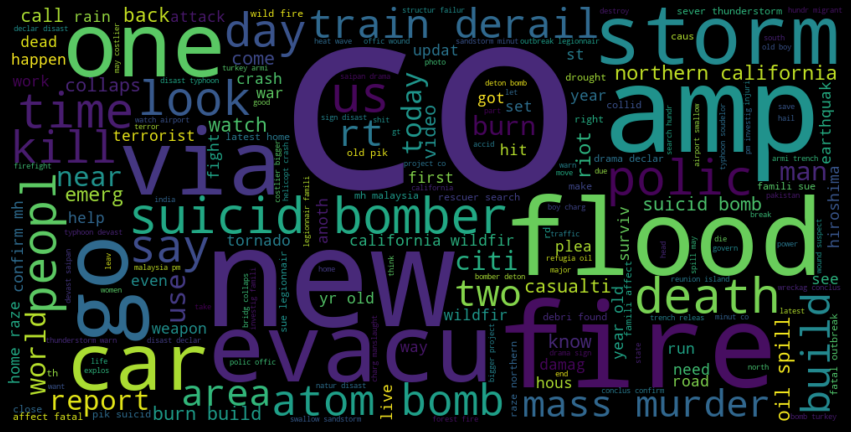

In [55]:
# Data Visualization using WordCloud (for Disaster)

disaster = ' '.join(list(train_df[train_df['target'] == 1] ['text']))
dis_wordcloud = WordCloud(width = 1000, height = 500).generate(disaster) # Generate a word cloud image
plt.figure(figsize = (15,8), facecolor = 'k')
plt.imshow(dis_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


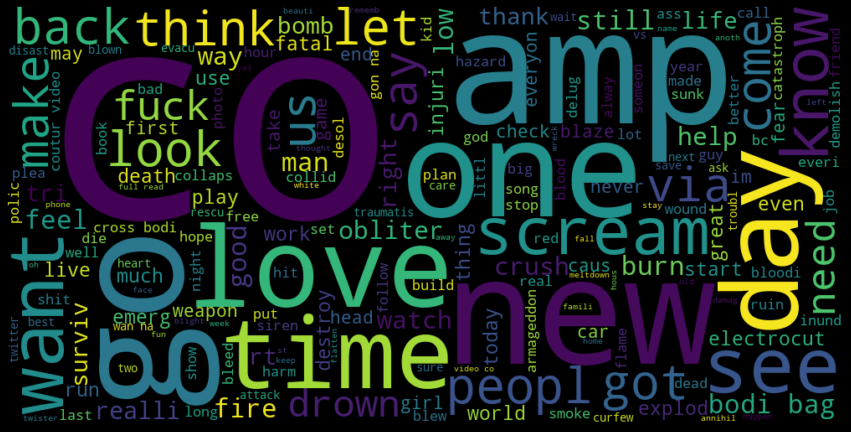

In [56]:
# Data Visualization using WordCloud (for non-Disaster)
non_disaster = ' '.join(list(train_df[train_df['target'] == 0] ['text']))
nondis_wordcloud = WordCloud(width = 1000, height = 500).generate(non_disaster) # Generate a word cloud image
plt.figure(figsize = (15,8), facecolor = 'k')
plt.imshow(nondis_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Let's look at our data... first, an example of what is NOT a disaster tweet.




In [57]:
train_df[train_df["target"] == 0]["text"].values[1]

'  love'

And one that is:

In [58]:
train_df[train_df["target"] == 1]["text"].values[1]

'  forest fire near la rang ask canada'


# Count Vectorizer

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's CountVectorizer to count the words in each tweet and turn them into data our machine learning model can process.

Note: a vector is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.


In [62]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])


In [63]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())


(1, 34)
[[0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]]




The above tells us that:

    1. There are 54 unique words (or "tokens") in the first five tweets.
    2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.


In [64]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.

test_vectors = count_vectorizer.transform(test_df["text"])



# Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a linear connection. So let's build a linear model and see!


In [65]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()




Let's test our model and see how well it does on the training data. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.


In [66]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.58990536, 0.55719921, 0.60068594])



The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.


In [29]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [31]:
sample_submission = pd.read_csv("sample_submission.csv")

In [32]:
sample_submission["target"] = clf.predict(test_vectors)

In [33]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [20]:
sample_submission.to_csv("submission.csv", index=False)



Now, in the viewer, you can submit the above file to the competition! Good luck!
